#Credit Card Fraud Detection

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from datetime import datetime
from datetime import timedelta
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import matthews_corrcoef
from sklearn import metrics
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from imblearn.under_sampling import RandomUnderSampler
import statistics as st

# **Data Loading**

In [ ]:
df = pd.read_json('/content/drive/MyDrive/Capital one data science challenge/transactions/transactions.json', lines=True)

In [ ]:
df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,,0.0,,,,False,,,False,False
1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,True,,,False,False
2,737265056,737265056,5000,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,False,,,False,False
3,737265056,737265056,5000,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,False,,,False,False
4,830329091,830329091,5000,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885,885,3143,PURCHASE,,0.0,,,,True,,,False,False


In [ ]:
df.shape

(786363, 29)

In [ ]:
#replacing empty cells with nan using regex function
df = df.replace(r'^\s*$',np.nan,regex=True)

In [ ]:
#check for data types of all the columns
df.dtypes

accountNumber                 int64
customerId                    int64
creditLimit                   int64
availableMoney              float64
transactionDateTime          object
transactionAmount           float64
merchantName                 object
acqCountry                   object
merchantCountryCode          object
posEntryMode                 object
posConditionCode             object
merchantCategoryCode         object
currentExpDate               object
accountOpenDate              object
dateOfLastAddressChange      object
cardCVV                       int64
enteredCVV                    int64
cardLast4Digits               int64
transactionType              object
echoBuffer                  float64
currentBalance              float64
merchantCity                float64
merchantState               float64
merchantZip                 float64
cardPresent                    bool
posOnPremises               float64
recurringAuthInd            float64
expirationDateKeyInMatch    

In [ ]:
#convert dtypes of all the data/time columns to datatime format
df[['transactionDateTime','dateOfLastAddressChange','accountOpenDate']] = df[['transactionDateTime','dateOfLastAddressChange','accountOpenDate']].apply(pd.to_datetime,format='%Y-%m-%d')
df['currentExpDate'] = pd.to_datetime(df['currentExpDate'], format='%m/%Y')

In [ ]:
df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13 14:27:32,98.55,Uber,US,US,02,01,rideshare,2023-06-01,2015-03-14,2015-03-14,414,414,1803,PURCHASE,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
1,737265056,737265056,5000,5000.0,2016-10-11 05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,2024-02-01,2015-03-14,2015-03-14,486,486,767,PURCHASE,NaN,0.0,NaN,NaN,NaN,True,NaN,NaN,False,False
2,737265056,737265056,5000,5000.0,2016-11-08 09:18:39,7.47,Play Store,US,US,09,01,mobileapps,2025-08-01,2015-03-14,2015-03-14,486,486,767,PURCHASE,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
3,737265056,737265056,5000,5000.0,2016-12-10 02:14:50,7.47,Play Store,US,US,09,01,mobileapps,2025-08-01,2015-03-14,2015-03-14,486,486,767,PURCHASE,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
4,830329091,830329091,5000,5000.0,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,2029-10-01,2015-08-06,2015-08-06,885,885,3143,PURCHASE,NaN,0.0,NaN,NaN,NaN,True,NaN,NaN,False,False


In [ ]:
#convert the final data frame to csv for further analysis
df.to_csv('/content/drive/MyDrive/Capital one data science challenge/transactions/transactions.csv')

In [ ]:
df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13 14:27:32,98.55,Uber,US,US,02,01,rideshare,2023-06-01,2015-03-14,2015-03-14,414,414,1803,PURCHASE,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
1,737265056,737265056,5000,5000.0,2016-10-11 05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,2024-02-01,2015-03-14,2015-03-14,486,486,767,PURCHASE,NaN,0.0,NaN,NaN,NaN,True,NaN,NaN,False,False
2,737265056,737265056,5000,5000.0,2016-11-08 09:18:39,7.47,Play Store,US,US,09,01,mobileapps,2025-08-01,2015-03-14,2015-03-14,486,486,767,PURCHASE,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
3,737265056,737265056,5000,5000.0,2016-12-10 02:14:50,7.47,Play Store,US,US,09,01,mobileapps,2025-08-01,2015-03-14,2015-03-14,486,486,767,PURCHASE,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
4,830329091,830329091,5000,5000.0,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,2029-10-01,2015-08-06,2015-08-06,885,885,3143,PURCHASE,NaN,0.0,NaN,NaN,NaN,True,NaN,NaN,False,False


# **Descriptive Statistics**

**Descriptive statistics of numerical variables (creditLimit, availableMoney, transactionAmount, currentBalance)**



In [ ]:
Name = []
Null = []
Min = []
first_quartile = []
Median = []
third_quartile = []
Max = []
Average = []

numerical_columns = ['creditLimit', 'availableMoney', 'transactionAmount', 'currentBalance']
for i in numerical_columns:
  Name.append(i)
  Null.append(df[i].isnull().sum())
  Min.append(df[i].min())
  first_quartile.append(df[i].quantile(0.25))
  Median.append(df[i].quantile(0.5))
  third_quartile.append(df[i].quantile(0.75))
  Max.append(df[i].max())
  Average.append(df[i].mean())

df_Desc_stat = pd.DataFrame({'Name': Name,
                                    'Null Count': Null,
                                    'Min': Min,
                                    '25th Percentile': first_quartile,
                                    'Median': Median,
                                    '75th Percentile': third_quartile,
                                    'Max': Max,
                                    'Average': Average})
Number_of_Columns = len(df.columns)
Number_of_Rows = len(df)
print('Number of Columns: ',Number_of_Columns)
print('Number of Rows: ',Number_of_Rows)

Number of Columns:  29
Number of Rows:  786363


We can see below that some companies credit card comapnies allow negative avaiLable money for some transactions.

In [ ]:
#Descriptive Statistics of Numerical Variables
df_Desc_stat

,Name,Null Count,Min,25th Percentile,Median,75th Percentile,Max,Average
0,creditLimit,0,250.00,5000.00,7500.00,15000.000,50000.00,10759.464459
1,availableMoney,0,-1005.63,1077.42,3184.86,7500.000,50000.00,6250.725369
2,transactionAmount,0,0.00,33.65,87.90,191.480,2011.54,136.985791
3,currentBalance,0,0.00,689.91,2451.76,5291.095,47498.81,4508.739089


**It can be seen below that as transaction amount increases, the probability of fraud increases.**

In [ ]:
higher_transaction_amnt = (df[df['transactionAmount'] > 200]['isFraud'].sum()/len(df[df['transactionAmount']>200]))*100
print('Probability of fraudulent transactions when transaction amount is greater than $200: {}%'.format(higher_transaction_amnt))

Probability of fraudulent transactions when transaction amount is greater than $200: 2.996250646440269%


In [ ]:
lower_transaction_amnt = (df[df['transactionAmount'] < 200]['isFraud'].sum()/len(df[df['transactionAmount']<200]))*100
print('Probability of fraudulent transactions when transaction amount is lower than $200: {}%'.format(lower_transaction_amnt))

Probability of fraudulent transactions when transaction amount is lower than $200: 1.1411306432281263%


In [ ]:
df[df['transactionAmount'] > 200]['isFraud'].value_counts()

False    180070
True       5562
Name: isFraud, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Histogram of fradulent and non fradulent transactions')

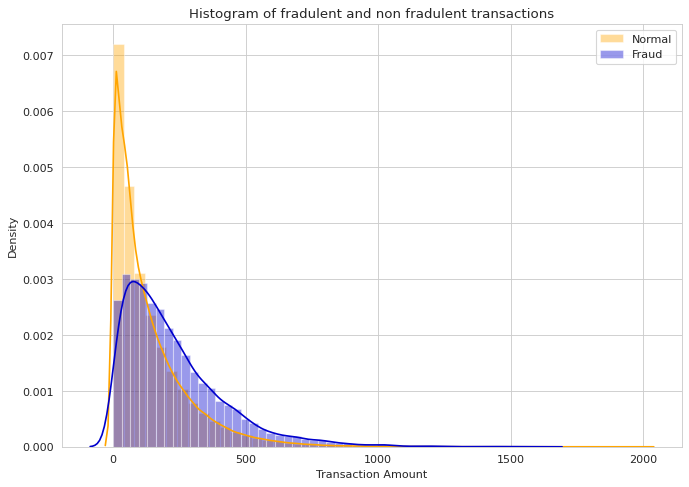

In [ ]:
plt.figure(figsize=(10,7), dpi= 80)
sns.set_style('whitegrid')
#sns.set(font_scale = 1.2)
sns.distplot(df[df['isFraud']==False]['transactionAmount'], hist=True, color='orange',
             label = 'Normal')
sns.distplot(df[df['isFraud']==True]['transactionAmount'], hist=True, color='mediumblue',
             label = 'Fraud')
plt.xlabel('Transaction Amount')
plt.legend()
plt.title('Histogram of fradulent and non fradulent transactions')

#Missing values in each variable

Each variable is checked for missing values and is handeled accordingly. Variables missing more than 60% of the values is removed and others are imputed based on if they are categorical or numerical.

In [ ]:
missing_values = []
ratio_missing_values = []
Column_Name = []

for j in df.columns:
  Column_Name.append(j)
  missing_values.append(df[j].isnull().sum())
  ratio_missing_values.append(df[j].isnull().sum()/len(df))

df_missing_values = pd.DataFrame({'Name': Column_Name, 'Missing Values': missing_values,
                                    'Ratio of Missing Values': ratio_missing_values})

In [ ]:
df_missing_values

,Name,Missing Values,Ratio of Missing Values
0,accountNumber,0,0.000000
1,customerId,0,0.000000
2,creditLimit,0,0.000000
3,availableMoney,0,0.000000
4,transactionDateTime,0,0.000000
5,transactionAmount,0,0.000000
6,merchantName,0,0.000000
7,acqCountry,4562,0.005801
8,merchantCountryCode,724,0.000921
9,posEntryMode,4054,0.005155


Drop the variables where more than 60% of the values are missing

In [ ]:
drop_columns = ['echoBuffer','merchantCity','merchantState','merchantZip','posOnPremises','recurringAuthInd']
df = df.drop(columns = drop_columns)

In [ ]:
missing_PEM_frd = df[df['isFraud']==True]['posEntryMode'].isna().sum() / sum(df['isFraud']==True)
print('proportion of fradulent transactions missing from posEntryMode variable',missing_PEM_frd)

proportion of fradulent transactions missing from posEntryMode variable 0.021663847950390593


In [ ]:
missing_PEM_nfrd = df[df['isFraud']==False]['posEntryMode'].isna().sum() / sum(df['isFraud']==False)
print('proportion of non fradulent transactions missing from posEntryMode variable',missing_PEM_nfrd)

proportion of non fradulent transactions missing from posEntryMode variable 0.0048905220777677


In [ ]:
missing_PCC_frd = df[df['isFraud']==True]['posConditionCode'].isna().sum() / sum(df['isFraud']==True)
print('proportion of fradulent transactions missing from posConditionCode variable',missing_PCC_frd)

proportion of fradulent transactions missing from posConditionCode variable 0.0017717645163888218


In [ ]:
missing_PCC_nfrd = df[df['isFraud']==False]['posConditionCode'].isna().sum() / sum(df['isFraud']==False)
print('proportion of non fradulent transactions missing from posConditionCode variable',missing_PCC_nfrd)

proportion of non fradulent transactions missing from posConditionCode variable 0.000500034886154848


In [ ]:
missing_TT_frd = df[df['isFraud']==True]['transactionType'].isna().sum() / sum(df['isFraud']==True)
print('proportion of fradulent transactions missing from transactionType variable',missing_TT_frd)

proportion of fradulent transactions missing from transactionType variable 0.0011274865104292503


In [ ]:
missing_TT_nfrd = df[df['isFraud']==False]['transactionType'].isna().sum() / sum(df['isFraud']==False)
print('proportion of non fradulent transactions missing from transactionType variable',missing_TT_nfrd)

proportion of non fradulent transactions missing from transactionType variable 0.0008837825894829872


In [ ]:
missing_MCC_frd = df[df['isFraud']==True]['merchantCountryCode'].isna().sum() / sum(df['isFraud']==True)
print('proportion of fradulent transactions missing from merchantCountryCode variable',missing_MCC_frd)

proportion of fradulent transactions missing from merchantCountryCode variable 0.006603849561085609


In [ ]:
missing_MCC_nfrd = df[df['isFraud']==False]['merchantCountryCode'].isna().sum() / sum(df['isFraud']==False)
print('proportion of non fradulent transactions missing from merchantCountryCode variable',missing_MCC_nfrd)

proportion of non fradulent transactions missing from merchantCountryCode variable 0.0008295152374971897


In [ ]:
missing_AC_frd = df[df['isFraud']==True]['acqCountry'].isna().sum() / sum(df['isFraud']==True)
print('proportion of fradulent transactions missing from acqCountry variable',missing_AC_frd)

proportion of fradulent transactions missing from acqCountry variable 0.01199967786099702


In [ ]:
missing_AC_nfrd = df[df['isFraud']==False]['acqCountry'].isna().sum() / sum(df['isFraud']==False)
print('proportion of non fradulent transactions missing from acqCountry variable',missing_AC_nfrd)

proportion of non fradulent transactions missing from acqCountry variable 0.00570194819793629


It can be seen that missing values have very high proportion of fradulent transaction. Hence, we define a new category called missing. This category can potentially help in categorizing fradulent transactions.

In [ ]:
df['posEntryMode'] = df['posEntryMode'].replace(np.nan, 'Missing', regex=True)
df['posConditionCode'] = df['posConditionCode'].replace(np.nan, 'Missing', regex=True)
df['transactionType'] = df['transactionType'].replace(np.nan, 'Missing', regex=True)
df['acqCountry'] = df['acqCountry'].replace(np.nan, 'Missing', regex=True)
df['merchantCountryCode'] = df['merchantCountryCode'].replace(np.nan, 'Missing', regex=True)

In [ ]:
df.shape

(786363, 23)

#Define new variables which can help in classifying the fradulent transactions.

Five new variables are defined:
<br>
<br>Variable1: Check for enteredCVV and cardCVV match (check if entered CVV and card CVV matches) 
<br>Variable2: Check for acqCountry and merchantCountryCode match (check if country where card was acquired and merchant country code matches)

In [ ]:
#Variable1
df['CVV_check'] = df['enteredCVV'] == df['cardCVV']

In [ ]:
#How many fradulent transactions contain CVV_check = False 
print('Number of CVV check = Fales:',sum(df['CVV_check']==False))
df[df['CVV_check']==False]['isFraud'].value_counts()

Number of CVV check = Fales: 7015


False    6812
True      203
Name: isFraud, dtype: int64

In [ ]:
#Variable2
df['acqMrchntCountrycheck'] = df['acqCountry'] == df['merchantCountryCode']

In [ ]:
#How many fradulent transactions contain CVV_check = False
print('Number of acqMrchntCountrycheck = Fales:',sum(df['acqMrchntCountrycheck']==False))
df[df['acqMrchntCountrycheck']==False]['isFraud'].value_counts()

Number of acqMrchntCountrycheck = Fales: 3911


False    3844
True       67
Name: isFraud, dtype: int64

Extract year, month and hour information from date time variables and visualize which individual variables might be potentially useful in classifying fraudulent transactions.

In [ ]:
df['accOpenYr'] = [i.year for i in df['accountOpenDate']]
df['transactionYr'] = [i.year for i in df['transactionDateTime']]
df['transactionMnth'] = [i.month for i in df['transactionDateTime']]
df['transactionHr'] = [i.hour for i in df['transactionDateTime']]
df['crntExpYr'] = [i.year for i in df['currentExpDate']]

Text(0.5, 1.0, 'Distribution of account open year')

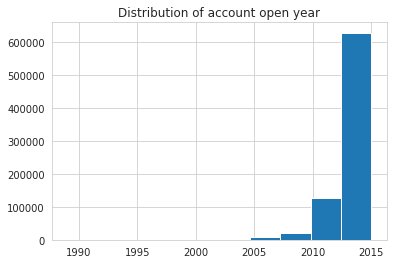

In [ ]:
df['accOpenYr'].hist()
plt.title('Distribution of account open year')

Text(0.5, 1.0, 'Distribution of Transactions by Month')

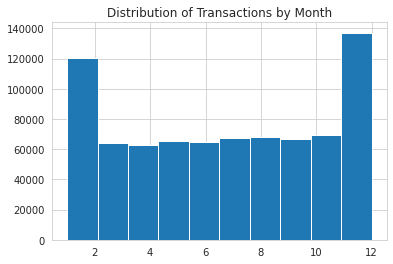

In [ ]:
df['transactionMnth'].hist()
plt.title('Distribution of Transactions by Month')

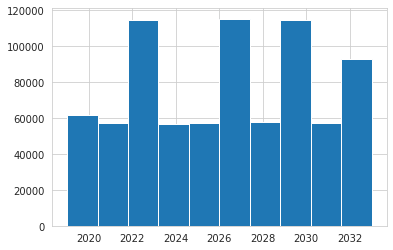

In [ ]:
df['crntExpYr'].hist()

Text(0.5, 1.0, 'Distribution of Traget Variable')

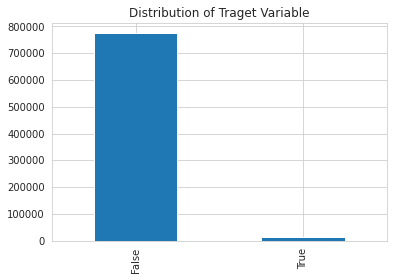

In [ ]:
df['isFraud'].value_counts().plot(kind='bar')
plt.title('Distribution of Traget Variable')

Text(0.5, 1.0, 'Fraud probability by hrs of transactions')

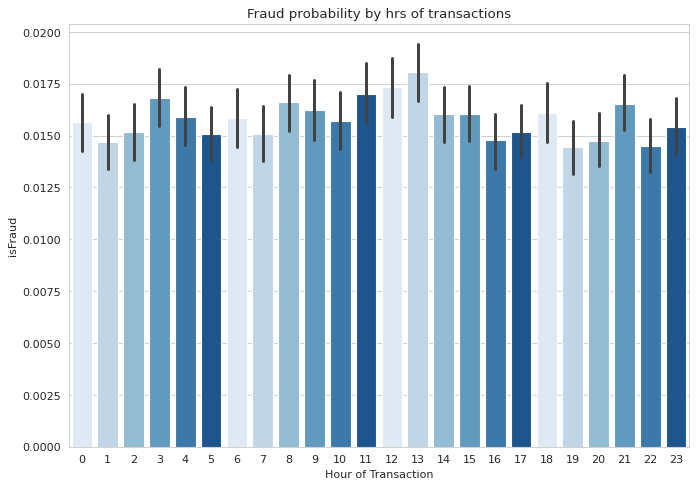

In [ ]:
plt.figure(figsize=(10,7), dpi= 80)
sns.barplot(x = 'transactionHr',
            y = 'isFraud',
            data = df,palette = sns.color_palette("Blues"))
plt.xlabel('Hour of Transaction')
plt.title('Fraud probability by hrs of transactions')

# Plot categorical variable to check how missing values classify fradulent transactions. 

Text(0.5, 1.0, 'probability of fradulent transactions - code for methods used to enter account number')

<Figure size 1120x800 with 0 Axes>

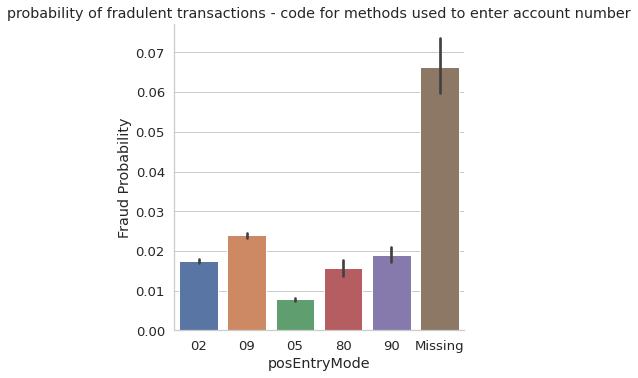

In [ ]:
plt.figure(figsize=(14,10), dpi= 80)
sns.set(style="whitegrid", font_scale=1.2)
plot1 = sns.catplot(x = 'posEntryMode', y = 'isFraud', data = df,kind = 'bar',
                palette="deep")
plot1.set_ylabels("Fraud Probability")
plt.title('probability of fradulent transactions - code for methods used to enter account number')

Text(0.5, 1.0, 'probability of fradulent transactions - code for transaction conditions at the point of sale/service')

<Figure size 1120x800 with 0 Axes>

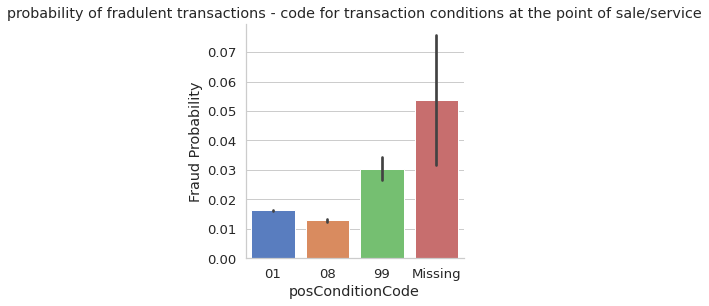

In [ ]:
plt.figure(figsize=(14,10), dpi= 80)
sns.set(style="whitegrid", font_scale=1.2)
plot2 = sns.catplot(x = 'posConditionCode', y = 'isFraud', data = df,
                height=4, kind="bar", palette="muted")
plot2.set_ylabels("Fraud Probability")
plt.title('probability of fradulent transactions - code for transaction conditions at the point of sale/service')

Text(0.5, 1.0, 'probability of fradulent transactions - Merchant Category')

<Figure size 1120x800 with 0 Axes>

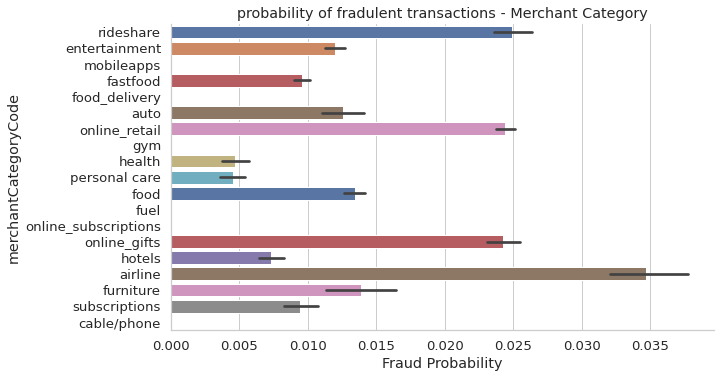

In [ ]:
plt.figure(figsize=(14,10), dpi= 80)
sns.set(style="whitegrid", font_scale=1.2)
plot3 = sns.catplot(y = 'merchantCategoryCode', x = 'isFraud', data = df,
                height=5, aspect=2 , kind="bar", palette="deep")
plot3.set_xlabels("Fraud Probability")
plt.title('probability of fradulent transactions - Merchant Category')

# Additional Exploratory Data Analysis





In [ ]:
df[df['isFraud']==False]['merchantCategoryCode'].value_counts(normalize=True) * 100

online_retail           25.482140
fastfood                14.350355
entertainment           10.225132
food                     9.622894
online_gifts             8.350970
rideshare                6.442827
hotels                   4.373303
fuel                     3.089363
subscriptions            2.931083
auto                     2.762208
health                   2.455210
personal care            2.439188
mobileapps               1.936828
airline                  1.922356
online_subscriptions     1.429945
furniture                0.946965
food_delivery            0.775248
gym                      0.285420
cable/phone              0.178565
Name: merchantCategoryCode, dtype: float64

In [ ]:
df[df['isFraud']==True]['merchantCategoryCode'].value_counts(normalize=True) * 100

online_retail    39.768060
online_gifts     12.933881
rideshare        10.244020
fastfood          8.649432
food              8.166224
entertainment     7.739390
airline           4.300556
auto              2.198599
hotels            2.013369
subscriptions     1.739551
furniture         0.829508
health            0.724813
personal care     0.692599
Name: merchantCategoryCode, dtype: float64

In [ ]:
df[df['isFraud']==False]['posConditionCode'].value_counts(normalize=True) * 100

01         79.922501
08         19.083760
99          0.943735
Missing     0.050003
Name: posConditionCode, dtype: float64

In [ ]:
df[df['isFraud']==True]['posConditionCode'].value_counts(normalize=True) * 100

01         82.387050
08         15.591528
99          1.844246
Missing     0.177176
Name: posConditionCode, dtype: float64

In [ ]:
df[df['isFraud']==False]['posEntryMode'].value_counts(normalize=True) * 100

05         40.387701
09         29.824045
02         24.874216
90          2.481310
80          1.943676
Missing     0.489052
Name: posEntryMode, dtype: float64

In [ ]:
df[df['isFraud']==True]['posEntryMode'].value_counts(normalize=True) * 100

09         45.574615
02         27.550938
05         19.779335
90          2.995893
Missing     2.166385
80          1.932834
Name: posEntryMode, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Fraud transaction probability by transaction type')

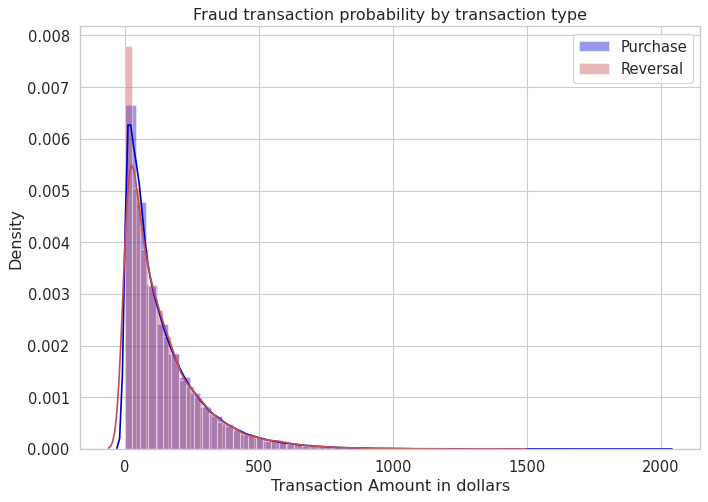

In [ ]:
plt.figure(figsize=(10,7), dpi= 80)
sns.distplot(df[df['transactionType']=='PURCHASE']['transactionAmount'], hist=True, color='mediumblue',
             label = 'Purchase',  norm_hist=True)
sns.distplot(df[df['transactionType']=='REVERSAL']['transactionAmount'], hist=True, color='r',
             label = 'Reversal',  norm_hist=True)
plt.xlabel('Transaction Amount in dollars')
plt.legend()
plt.title('Fraud transaction probability by transaction type')

In [ ]:
df['isFraud'].value_counts()

False    773946
True      12417
Name: isFraud, dtype: int64

## Data Wrangling - Duplicate Transactions

#Reversed and multi-swipe transactions:

**Reversed Transactions:** Transaction where purchase is followed by reversal

**Multi-Swipe Transaction:** Transaction where vendor accidentally charges a customer's card multiple times within a short time span

In [ ]:
df['transaction_rank'] = df.groupby('customerId')['transactionDateTime'].rank('dense', ascending=True)

In [ ]:
df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,CVV_check,acqMrchntCountrycheck,accOpenYr,transactionYr,transactionMnth,transactionHr,crntExpYr,transaction_rank
0,737265056,737265056,5000,5000.0,2016-08-13 14:27:32,98.55,Uber,US,US,02,01,rideshare,2023-06-01,2015-03-14,2015-03-14,414,414,1803,PURCHASE,0.0,False,False,False,True,True,2015,2016,8,14,2023,1.0
1,737265056,737265056,5000,5000.0,2016-10-11 05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,2024-02-01,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,True,False,False,True,True,2015,2016,10,5,2024,2.0
2,737265056,737265056,5000,5000.0,2016-11-08 09:18:39,7.47,Play Store,US,US,09,01,mobileapps,2025-08-01,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,False,False,False,True,True,2015,2016,11,9,2025,3.0
3,737265056,737265056,5000,5000.0,2016-12-10 02:14:50,7.47,Play Store,US,US,09,01,mobileapps,2025-08-01,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,False,False,False,True,True,2015,2016,12,2,2025,4.0
4,830329091,830329091,5000,5000.0,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,2029-10-01,2015-08-06,2015-08-06,885,885,3143,PURCHASE,0.0,True,False,False,True,True,2015,2016,3,21,2029,1.0


In [ ]:
def DuplicateTransactions(df,index,row):
    row_customerId = row['customerId']
    row_ranking = row['transaction_rank']
    row_merchantName = row['merchantName']
    row_merchantCountryCode = row['merchantCountryCode']
    row_transaction_time = row['transactionDateTime']
    row_transactionAmount = row['transactionAmount']
    row_availableMoney = float(row['availableMoney'])

    #subset of customerID without address changes
    subset_df = df[df['customerId']==row_customerId]

    #subset of similar transactions
    similar_transactions = subset_df[(subset_df['merchantName']==row_merchantName) &
                             (subset_df['merchantCountryCode']==row_merchantCountryCode) &
                             (row_transaction_time > subset_df['transactionDateTime']) &
                             (subset_df['transaction_rank'] < row_ranking) &
                             (subset_df['transactionAmount'] == row_transactionAmount) ] #the row itself is not included

    #Reversal transactions
    nxt_transaction = subset_df[subset_df['transaction_rank']==(row_ranking+1)]
    if nxt_transaction.empty==False:
        nxt_transaction = nxt_transaction.iloc[0]
    
    if nxt_transaction.empty==False and (row_transactionAmount!=0) and (round(nxt_transaction['availableMoney'],2) == round(row_availableMoney + row_transactionAmount, 2)):
        reversal = True
        doubleSwipe = False
    else:
        reversal = False

        #double swipe transaction
        if row_transactionAmount!=0 and len(similar_transactions[row_transaction_time - timedelta(days=0, hours=0, minutes=5) < similar_transactions['transactionDateTime']]) >= 1:
            doubleSwipe = True
        else:
            doubleSwipe = False
    output = (reversal,doubleSwipe)
    return output

In [ ]:
reversal_transaction = []
doubleSwipe_transaction = []
for index, row in df.iterrows():
    dupl_transaction = DuplicateTransactions(df,index,row)
    reversal_transaction.append(dupl_transaction[0])
    doubleSwipe_transaction.append(dupl_transaction[1])
    
df['reversal_ind'] = reversal_transaction
df['doubleSwipe_ind'] = doubleSwipe_transaction

In [ ]:
df.shape

(786363, 33)

In [ ]:
df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,CVV_check,acqMrchntCountrycheck,accOpenYr,transactionYr,transactionMnth,transactionHr,crntExpYr,transaction_rank,reversal_ind,doubleSwipe_ind
0,737265056,737265056,5000,5000.0,2016-08-13 14:27:32,98.55,Uber,US,US,02,01,rideshare,2023-06-01,2015-03-14,2015-03-14,414,414,1803,PURCHASE,0.0,False,False,False,True,True,2015,2016,8,14,2023,1.0,False,False
1,737265056,737265056,5000,5000.0,2016-10-11 05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,2024-02-01,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,True,False,False,True,True,2015,2016,10,5,2024,2.0,False,False
2,737265056,737265056,5000,5000.0,2016-11-08 09:18:39,7.47,Play Store,US,US,09,01,mobileapps,2025-08-01,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,False,False,False,True,True,2015,2016,11,9,2025,3.0,False,False
3,737265056,737265056,5000,5000.0,2016-12-10 02:14:50,7.47,Play Store,US,US,09,01,mobileapps,2025-08-01,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,False,False,False,True,True,2015,2016,12,2,2025,4.0,False,False
4,830329091,830329091,5000,5000.0,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,2029-10-01,2015-08-06,2015-08-06,885,885,3143,PURCHASE,0.0,True,False,False,True,True,2015,2016,3,21,2029,1.0,False,False


Text(0.5, 1.0, 'probability of fradulent transactions - Double swipe transactions')

<Figure size 1120x800 with 0 Axes>

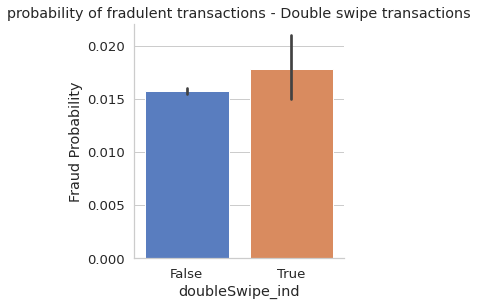

In [ ]:
plt.figure(figsize=(14,10), dpi= 80)
sns.set(style="whitegrid", font_scale=1.2)
plot2 = sns.catplot(x = 'doubleSwipe_ind', y = 'isFraud', data = df,
                height=4, kind="bar", palette="muted")
plot2.set_ylabels("Fraud Probability")
plt.title('probability of fradulent transactions - Multi-Swiped Transactions')

Text(0.5, 1.0, 'probability of fradulent transactions - Reversed Transactions')

<Figure size 1120x800 with 0 Axes>

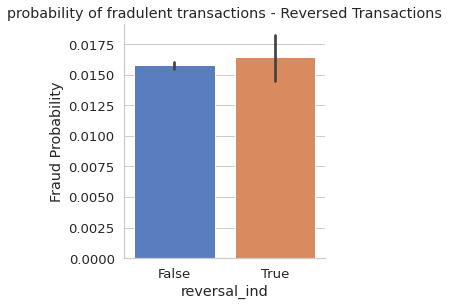

In [ ]:
plt.figure(figsize=(14,10), dpi= 80)
sns.set(style="whitegrid", font_scale=1.2)
plot2 = sns.catplot(x = 'reversal_ind', y = 'isFraud', data = df,
                height=4, kind="bar", palette="muted")
plot2.set_ylabels("Fraud Probability")
plt.title('probability of fradulent transactions - Reversed Transactions')

# Model Building

In [ ]:
df.shape

(786363, 33)

In [ ]:
df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,CVV_check,acqMrchntCountrycheck,accOpenYr,transactionYr,transactionMnth,transactionHr,crntExpYr,transaction_rank,reversal_ind,doubleSwipe_ind
0,737265056,737265056,5000,5000.0,2016-08-13 14:27:32,98.55,Uber,US,US,02,01,rideshare,2023-06-01,2015-03-14,2015-03-14,414,414,1803,PURCHASE,0.0,False,False,False,True,True,2015,2016,8,14,2023,1.0,False,False
1,737265056,737265056,5000,5000.0,2016-10-11 05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,2024-02-01,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,True,False,False,True,True,2015,2016,10,5,2024,2.0,False,False
2,737265056,737265056,5000,5000.0,2016-11-08 09:18:39,7.47,Play Store,US,US,09,01,mobileapps,2025-08-01,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,False,False,False,True,True,2015,2016,11,9,2025,3.0,False,False
3,737265056,737265056,5000,5000.0,2016-12-10 02:14:50,7.47,Play Store,US,US,09,01,mobileapps,2025-08-01,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,False,False,False,True,True,2015,2016,12,2,2025,4.0,False,False
4,830329091,830329091,5000,5000.0,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,2029-10-01,2015-08-06,2015-08-06,885,885,3143,PURCHASE,0.0,True,False,False,True,True,2015,2016,3,21,2029,1.0,False,False


In [ ]:
final_features = ['acqCountry','merchantCountryCode','posEntryMode','posConditionCode','merchantCategoryCode','transactionType','cardPresent','expirationDateKeyInMatch','CVV_check','acqMrchntCountrycheck','transactionMnth','transactionHr','creditLimit','availableMoney','transactionAmount','currentBalance']

In [ ]:
new_df = df[final_features]

In [ ]:
new_df.shape

(786363, 16)

In [ ]:
categorical_features = ['acqCountry','merchantCountryCode','posEntryMode','posConditionCode','merchantCategoryCode','transactionType','cardPresent','expirationDateKeyInMatch','CVV_check','acqMrchntCountrycheck','transactionMnth','transactionHr']
print(len(categorical_features))

12


In [ ]:
oneHotEncoded_features = pd.get_dummies(new_df[categorical_features])

In [ ]:
oneHotEncoded_features.shape
oneHotEncoded_features.head()

,cardPresent,expirationDateKeyInMatch,CVV_check,acqMrchntCountrycheck,transactionMnth,transactionHr,acqCountry_CAN,acqCountry_MEX,acqCountry_Missing,acqCountry_PR,acqCountry_US,merchantCountryCode_CAN,merchantCountryCode_MEX,merchantCountryCode_Missing,merchantCountryCode_PR,merchantCountryCode_US,posEntryMode_02,posEntryMode_05,posEntryMode_09,posEntryMode_80,posEntryMode_90,posEntryMode_Missing,posConditionCode_01,posConditionCode_08,posConditionCode_99,posConditionCode_Missing,merchantCategoryCode_airline,merchantCategoryCode_auto,merchantCategoryCode_cable/phone,merchantCategoryCode_entertainment,merchantCategoryCode_fastfood,merchantCategoryCode_food,merchantCategoryCode_food_delivery,merchantCategoryCode_fuel,merchantCategoryCode_furniture,merchantCategoryCode_gym,merchantCategoryCode_health,merchantCategoryCode_hotels,merchantCategoryCode_mobileapps,merchantCategoryCode_online_gifts,merchantCategoryCode_online_retail,merchantCategoryCode_online_subscriptions,merchantCategoryCode_personal care,merchantCategoryCode_rideshare,merchantCategoryCode_subscriptions,transactionType_ADDRESS_VERIFICATION,transactionType_Missing,transactionType_PURCHASE,transactionType_REVERSAL
0,False,False,True,True,8,14,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,True,False,True,True,10,5,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,False,False,True,True,11,9,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
3,False,False,True,True,12,2,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
4,True,False,True,True,3,21,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
numerical_features = ['creditLimit','availableMoney','transactionAmount','currentBalance']

In [ ]:
new_df_numerical_features = new_df[numerical_features]

In [ ]:
new_df = new_df_numerical_features.join(oneHotEncoded_features)

In [ ]:
new_df

,creditLimit,availableMoney,transactionAmount,currentBalance,cardPresent,expirationDateKeyInMatch,CVV_check,acqMrchntCountrycheck,transactionMnth,transactionHr,acqCountry_CAN,acqCountry_MEX,acqCountry_Missing,acqCountry_PR,acqCountry_US,merchantCountryCode_CAN,merchantCountryCode_MEX,merchantCountryCode_Missing,merchantCountryCode_PR,merchantCountryCode_US,posEntryMode_02,posEntryMode_05,posEntryMode_09,posEntryMode_80,posEntryMode_90,posEntryMode_Missing,posConditionCode_01,posConditionCode_08,posConditionCode_99,posConditionCode_Missing,merchantCategoryCode_airline,merchantCategoryCode_auto,merchantCategoryCode_cable/phone,merchantCategoryCode_entertainment,merchantCategoryCode_fastfood,merchantCategoryCode_food,merchantCategoryCode_food_delivery,merchantCategoryCode_fuel,merchantCategoryCode_furniture,merchantCategoryCode_gym,merchantCategoryCode_health,merchantCategoryCode_hotels,merchantCategoryCode_mobileapps,merchantCategoryCode_online_gifts,merchantCategoryCode_online_retail,merchantCategoryCode_online_subscriptions,merchantCategoryCode_personal care,merchantCategoryCode_rideshare,merchantCategoryCode_subscriptions,transactionType_ADDRESS_VERIFICATION,transactionType_Missing,transactionType_PURCHASE,transactionType_REVERSAL
0,5000,5000.00,98.55,0.00,False,False,True,True,8,14,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
1,5000,5000.00,74.51,0.00,True,False,True,True,10,5,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,5000,5000.00,7.47,0.00,False,False,True,True,11,9,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
3,5000,5000.00,7.47,0.00,False,False,True,True,12,2,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
4,5000,5000.00,71.18,0.00,True,False,True,True,3,21,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786358,50000,48904.96,119.92,1095.04,False,False,True,True,12,18,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
786359,50000,48785.04,18.89,1214.96,False,False,True,True,12,16,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
786360,50000,48766.15,49.43,1233.85,False,False,True,True,12,15,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
786361,50000,48716.72,49.89,1283.28,False,False,True,True,12,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0


In [ ]:
new_df.to_csv('/content/drive/MyDrive/Capital one data science challenge/transactions/MLtransactions.csv')

Text(0.5, 1.0, 'Correlation Matrix')

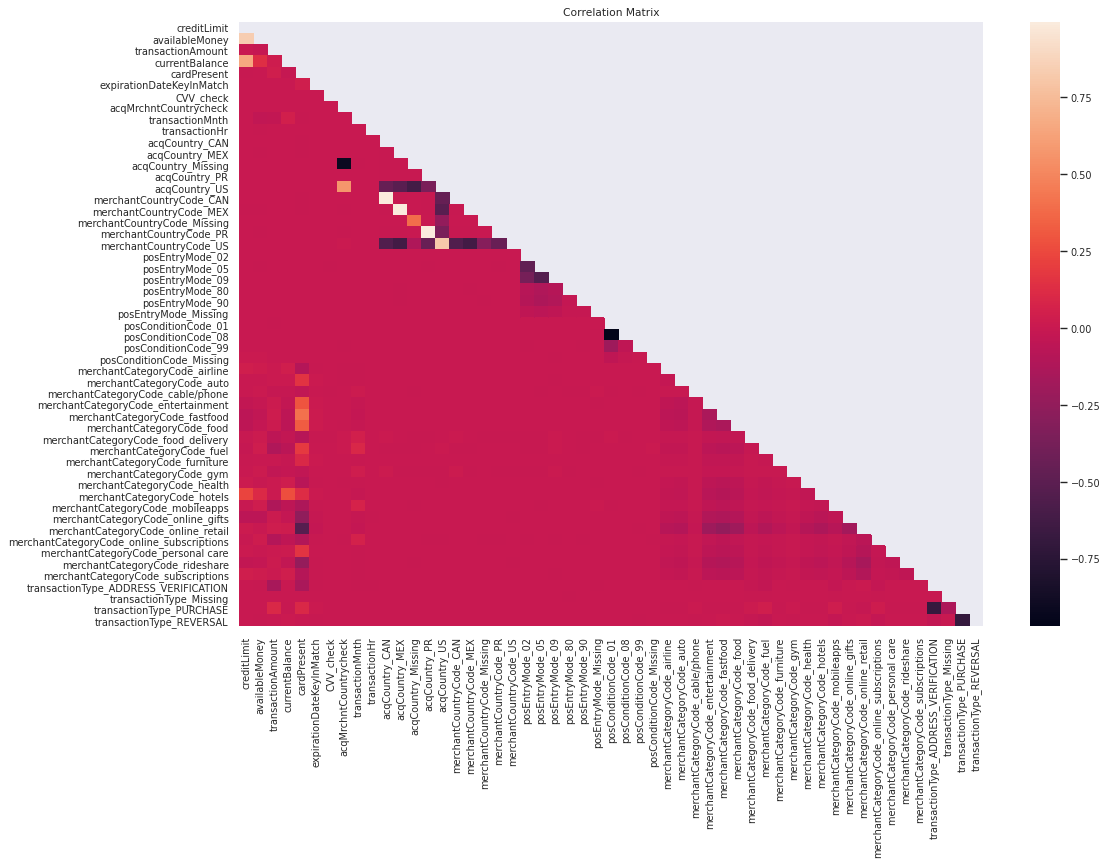

In [ ]:
#Correlation Matrix
plt.figure(figsize=(15,10), dpi= 80)
sns.set(font_scale=0.8)
matrix = np.triu(new_df.corr())
sns.heatmap(new_df.corr(),
            #annot = True,
            
            mask = matrix)
plt.title('Correlation Matrix')

In [ ]:
#Converting boolean to int
y = pd.factorize(df['isFraud'])[0]
print(y)
print(sum(y==1))

[0 0 0 ... 0 0 0]
12417


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(new_df, y, test_size=0.30)

In [ ]:
#checking if the dataset is unbalanced
print('percentage of fraudulent transactions in training dataset: ',sum(y_train==1)/len(y_train))
print('percentage of fraudulent transactions in testing dataset: ',sum(y_test==1)/len(y_test))

percentage of fraudulent transactions in training dataset:  0.01564345067889415
percentage of fraudulent transactions in testing dataset:  0.016133339550419866


In [ ]:
#Random Under Sampling
randomus = RandomUnderSampler(random_state=101)
X_trn_randomus, y_trn_randomus = randomus.fit_resample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
print('X_train after random under sampling shape: ',X_trn_randomus.shape)
print('y_train after random under sampling shape: ',y_trn_randomus.shape)

X_train after random under sampling shape:  (17222, 53)
y_train after random under sampling shape:  (17222,)


In [ ]:
print('percentage of fradulent transactions:',sum(y_trn_randomus==1)/len(y_trn_randomus))

percentage of fradulent transactions: 0.5


In [ ]:
#Random Forest algorithm
Randomfc = RandomForestClassifier(random_state = 101)

parameters = { 
    'n_estimators': [300, 350, 400],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']}

score = make_scorer(recall_score)

rus_gs = GridSearchCV(estimator=Randomfc,
                   param_grid = parameters,
                   cv = 5,
                   scoring = score)

rus_gs.fit(X_trn_randomus, y_trn_randomus)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=101,
                                 

In [ ]:
rus_gs.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=101,
                       verbose=0, warm_start=False)

In [ ]:
#Recall score
rus_gs.best_score_

0.6975960951882133

In [ ]:
feature_name = []
feature_importance = []
for feature, importance in zip(new_df.columns, rus_gs.best_estimator_.feature_importances_):
    feature_name.append(feature)
    feature_importance.append(importance)
imp_feature_df = pd.DataFrame({'Feature Name': feature_name,
                                  'Feature Importance': feature_importance})
imp_feature_df.sort_values(by=['Feature Importance'], ascending=False).head(20)

,Feature Name,Feature Importance
2,transactionAmount,0.202191
3,currentBalance,0.147576
1,availableMoney,0.146642
9,transactionHr,0.113119
8,transactionMnth,0.094146
0,creditLimit,0.067890
21,posEntryMode_05,0.026695
4,cardPresent,0.017581
22,posEntryMode_09,0.014035
44,merchantCategoryCode_online_retail,0.011399


We can see that only ~1.6% of the transactions are fradulent. Because of this, the model wont be able to generalize well and it will tend to predict the majority class (in our case no fraud).This wont help us in classifying fradulent transactions and hence, To tackle this problem, we use Random undersampling/oversampling techniques to balance the dataset.

First, we use SMOTE technique for oversampling

We can see that that the fradulent and non-fradulent transactions are balanced now

Text(0.5, 1.0, 'Selection of Important Features using Random Forest')

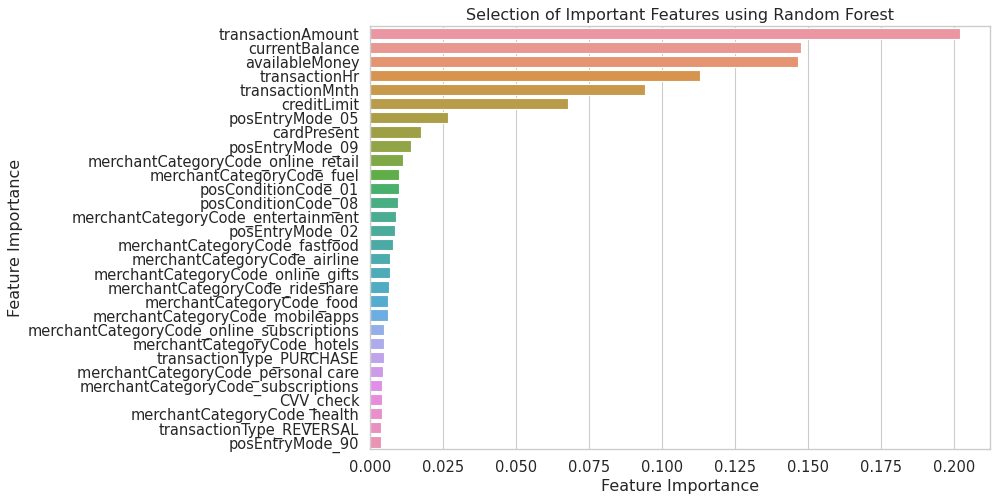

In [ ]:
plt.figure(figsize=(10,7), dpi= 80)
sns.set(font_scale = 1.2,
       style = 'whitegrid')
fi_plot = sns.barplot(data = imp_feature_df.sort_values(by=['Feature Importance'], ascending=False)[0:30],
            y = 'Feature Name', x = 'Feature Importance')
plt.ylabel("Feature Importance")
plt.title('Selection of Important Features using Random Forest')

In [ ]:
#Additional performance measures:
y_randomus_pred = rus_gs.predict(X_test)
MCC = matthews_corrcoef(y_test, y_randomus_pred)
print('Mathews Corr Coef: ', MCC)
F1 = f1_score(y_test, y_randomus_pred, average='weighted')
print('F1 Score: ', F1)
#f2_score = fbeta_score(y_test, y_pred_smote_tomek, beta=2)
#fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_smote, pos_label=1)
#AUC = metrics.auc(fpr, tpr)
#print('AUC-ROC= ', AUC)
RECALL = recall_score(y_test, y_randomus_pred)#, average='weighted')
print('Recall: ', RECALL)
PRECISION = precision_score(y_test, y_randomus_pred)#, average='weighted')
print('Precision: ', PRECISION)

Mathews Corr Coef:  0.10662141874338721
F1 Score:  0.805476664791093
Recall:  0.6970572779821335
Precision:  0.036105553967800325


Text(0.5, 1.0, 'Confusion Matrix')

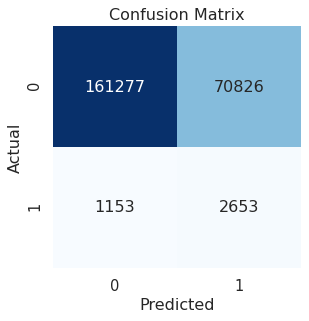

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test, y_randomus_pred)
plt.figure(figsize=(4,4), dpi= 80)
sns.set(font_scale = 1.2,
       style = 'whitegrid')
sns.heatmap(confusion_matrix, annot=True,
            cmap='Blues', cbar = False,
           fmt = '.0f')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title('Confusion Matrix')